## Overview
This is a 14-class classification problem.

### Preprocess

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../../CHESTXRAY/Data_Entry_2017.csv')
df = df.sample(frac=1)  # shuffle dataframe
image_dir = '../../images'
image_path = {f:os.path.join(image_dir,f) for f in os.listdir(image_dir)}
print("Scans found: {}, total headers: {}".format(len(image_path), df.shape[0]))
df['path'] = df['Image Index'].map(image_path.get)  # add path column
# note: df['Patient Age'] has value larger than 100
df.sample(3)

Scans found: 112120, total headers: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
69852,00017216_001.png,No Finding,1,17216,40,M,PA,2992,2991,0.143,0.143,NaN,../../images/00017216_001.png
38152,00010007_071.png,Effusion|Infiltration,71,10007,58,M,AP,2500,2048,0.168,0.168,NaN,../../images/00010007_071.png
66980,00016557_001.png,Mass|Nodule,1,16557,52,M,AP,2500,2048,0.168,0.168,NaN,../../images/00016557_001.png


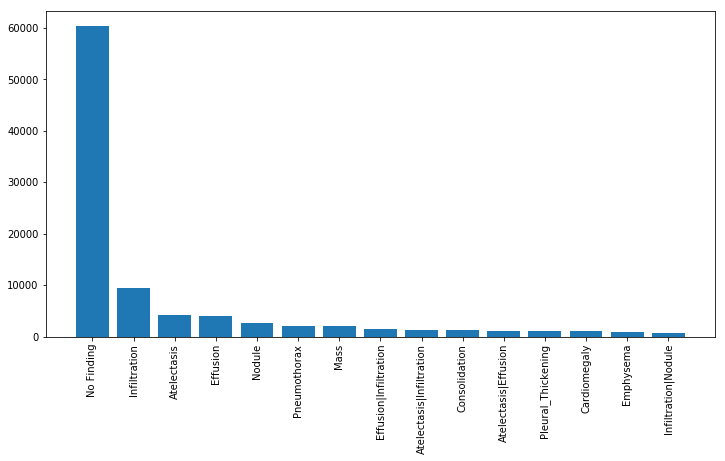

In [4]:
label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 6))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [5]:
from itertools import chain
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(len(all_labels), all_labels)
for c_label in all_labels:
    df[c_label] = df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
df.sample(3)

15 ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
24859,00006522_007.png,No Finding,7,6522,54,F,AP,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
32629,00008522_052.png,Consolidation|Infiltration,52,8522,61,F,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,0,0
2619,00000690_000.png,No Finding,0,690,41,F,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0


In [6]:
classes = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
           'Emphysema','Fibrosis','Hernia','Infiltration','Mass','Nodule',
           'Pleural_Thickening','Pneumonia','Pneumothorax']
nb_records, nb_classes = df.shape[0], len(classes)
print(nb_records, nb_classes)

112120 14


In [7]:
train_df = df.iloc[:int(nb_records*0.7)]
valid_df = df.iloc[int(nb_records*0.7):int(nb_records*0.9)]
test_df = df.iloc[int(nb_records*0.9):]
print(train_df.shape, valid_df.shape, test_df.shape)

(78484, 28) (22424, 28) (11212, 28)


### Build and train model

In [8]:
from models import ModelFactory

image_shape = (224, 224, 3)  # input image shape
model = ModelFactory(nb_classes, image_shape).densenet121()
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [9]:
from keras.optimizers import Adam

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
from class_weights import get_class_weights
class_weights = get_class_weights(df, classes)
print(class_weights)

[{0: 0.10309489832322512, 1: 0.8969051016767748}, {0: 0.024759186585800928, 1: 0.9752408134141991}, {0: 0.0416250445950767, 1: 0.9583749554049233}, {0: 0.020540492329646807, 1: 0.9794595076703532}, {0: 0.11877452729218695, 1: 0.881225472707813}, {0: 0.022440242597217268, 1: 0.9775597574027828}, {0: 0.015037459864430967, 1: 0.984962540135569}, {0: 0.0020246164823403494, 1: 0.9979753835176597}, {0: 0.17743489118801284, 1: 0.8225651088119872}, {0: 0.05156974669996432, 1: 0.9484302533000357}, {0: 0.05646628612201213, 1: 0.9435337138779879}, {0: 0.030190866928291118, 1: 0.9698091330717089}, {0: 0.012763110952550838, 1: 0.9872368890474491}, {0: 0.04728861933642526, 1: 0.9527113806635747}]


/home/pneumoconiosis/models/cnn6_DenseNet121/class_weights.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  labels = df[classes_key].as_matrix()


In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="weights_{epoch:03d}_{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)
# early = EarlyStopping(monitor="acc", mode="max", patience=3)
reduceLR = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1, 
                             mode="min", min_lr=1e-8)
callbacks = [checkpoint, reduceLR]

In [12]:
from generator import DataGenerator

batch_size = 32

train_generator = DataGenerator(train_df, path_key="path", classes_key=classes, batch_size=batch_size)
valid_generator = DataGenerator(valid_df, path_key="path", classes_key=classes, batch_size=batch_size, shuffle=False)
print(len(train_generator), len(valid_generator))

2453 701


In [ ]:
nb_epoch = 200

history = model.fit_generator(generator=train_generator, 
                              epochs=nb_epoch, 
                              validation_data=valid_generator, 
                              callbacks=callbacks, 
                              class_weight=class_weights, 
                              verbose=1,
                              workers=6, 
                              shuffle=False)

Epoch 1/200
2453/2453 [==============================] - 662s 270ms/step - loss: 0.1690 - acc: 0.9479 - val_loss: 0.1770 - val_acc: 0.9464

Epoch 00001: acc improved from -inf to 0.94787, saving model to weights_001_0.1770.hdf5
Epoch 2/200
2453/2453 [==============================] - 642s 262ms/step - loss: 0.1612 - acc: 0.9484 - val_loss: 0.1694 - val_acc: 0.9442

Epoch 00002: acc improved from 0.94787 to 0.94842, saving model to weights_002_0.1694.hdf5
Epoch 3/200
2453/2453 [==============================] - 644s 262ms/step - loss: 0.1575 - acc: 0.9488 - val_loss: 0.1641 - val_acc: 0.9489

Epoch 00003: acc improved from 0.94842 to 0.94876, saving model to weights_003_0.1641.hdf5
Epoch 4/200
2453/2453 [==============================] - 644s 262ms/step - loss: 0.1546 - acc: 0.9489 - val_loss: 0.1992 - val_acc: 0.9432

Epoch 00004: acc improved from 0.94876 to 0.94894, saving model to weights_004_0.1992.hdf5
Epoch 5/200
2453/2453 [==============================] - 642s 262ms/step - loss